# Assignment 3.2

Suraj Iyer (866094)  
Sander Boelders (0916836)


# Sequence classification model

In [0]:
from __future__ import print_function

## 1. Preprocess data

#### Tasks:

* Create word vocabulary index (use 10.000 most frequent words)
* Preprocess training and validation set for model input. Use vocabulary index as lookup dictionary to transform raw text into integer sequences. You may use code from Practical 5.

In [0]:
import os
import sys
import numpy as np
import pandas as pd
import re
import nltk

In [0]:
!rm *
download_from_gdrive('data.zip', '1Saog0mTVLiw1KZb2Bol2gzM9KbsycHN3')
!unzip data.zip

Download 100%.
Archive:  data.zip
  inflating: char_indices.npy        
  inflating: indices_char.npy        
  inflating: indices_words.npy       
  inflating: trainingData.tsv        
  inflating: unlabeledData.tsv       
  inflating: validationData.tsv      
  inflating: words_indices.npy       
  inflating: X_train_char.npy        
  inflating: X_train_word.npy        
  inflating: X_valid_char.npy        
  inflating: X_valid_word.npy        
  inflating: y_train_char.npy        
  inflating: y_train_word.npy        
  inflating: y_valid_char.npy        
  inflating: y_valid_word.npy        


In [0]:
from IPython.display import clear_output
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload

def download_from_gdrive(file_name, file_id):
  """Download a file from google drive.
  
  Attributes:
    file_name: string
      Name to save the file with.
    
    file_id: string
      A file ID looks like: 1uBtlaggVyWshwcyP6kEI-y_W3P8D26sz
  """

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = open(file_name, "wb")
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  current_progress = -1

  while done is False:
    status, done = downloader.next_chunk()
    if status:
      if current_progress != status.progress():
        current_progress = status.progress()
        clear_output(wait=True)
        print("Download %d%%." % int(current_progress * 100))

In [0]:
# YOUR CODE HERE 
DATA_PATH = 'data'
EMBEDDING_PATH = 'embedding'
MODEL_PATH = 'model'

#Loading the vocabulary index generated using code from Practical 5.
np_indices_words = np.load(os.path.join('indices_words.npy'))

word_indices = np_indices_words.item()

# provide model inputs (sequences from training and validation set) and outputs (sentiment labels)
x_train = np.load(os.path.join('X_train_word.npy'))
y_train = np.load(os.path.join('y_train_word.npy'))
x_validation = np.load(os.path.join('X_valid_word.npy'))
y_validation = np.load(os.path.join('y_valid_word.npy'))

# here we only use smaller set to train our model 
# original set consists of 25.000 reviews

x_train = x_train[:5000]
y_train = y_train[:5000]

x_validation = x_validation[5000:6000]
y_validation = y_validation[5000:6000]

## 2. Sequence classification model

#### Tasks: 

* Create a RNN model to classify sequence of words on a binary classification task
* Compare four (4) different gate memory units
* Plot model performance (loss and accuracy) of these 4 models
* Present the performance (loss and accuarcy) of these 4 models in a comparison table

In [0]:
# YOUR CODE HERE 
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Bidirectional
from keras.layers import LSTM, Lambda
import tensorflow as tf
import keras.callbacks

# decide number of epochs and batch_size
num_epochs = 5
batch_size = 64

num_words = len(word_indices)
max_sequence_length = 500
rnn_dim = 32

def binarize(x, sz=num_words):
    return tf.to_float(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1))

def binarize_outshape(in_shape):
    return in_shape[0], in_shape[1], num_words

### Model 1 : LSTM

In [0]:
# YOUR CODE HERE
# MODEL-1: LSTM

# construct architecture
input_layer = Input(shape=(max_sequence_length, ), name='input_layer', dtype='int32')
char_embedding = Lambda(binarize, output_shape=binarize_outshape,name='char_embedding')(input_layer)
lstm_layer = LSTM(rnn_dim, name='lstm_layer')(char_embedding)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(lstm_layer)

# define and load model
lstm_model = Model(inputs=input_layer, outputs=output_layer)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
char_embedding (Lambda)      (None, 500, 10004)        0         
_________________________________________________________________
lstm_layer (LSTM)            (None, 32)                1284736   
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 33        
Total params: 1,284,769
Trainable params: 1,284,769
Non-trainable params: 0
_________________________________________________________________


### Model 2: GRU

In [0]:
# YOUR CODE HERE
# MODEL-2: GRU
from keras.layers import GRU

# construct architecture
input_layer = Input(shape=(max_sequence_length, ), name='input_layer', dtype='int32')
char_embedding = Lambda(binarize, output_shape=binarize_outshape,name='char_embedding')(input_layer)
GRU_layer = GRU(rnn_dim, name='GRU_layer')(char_embedding)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(GRU_layer)

# define and load model
gru_model = Model(inputs=input_layer, outputs=output_layer)
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
char_embedding (Lambda)      (None, 500, 10004)        0         
_________________________________________________________________
GRU_layer (GRU)              (None, 32)                963552    
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 33        
Total params: 963,585
Trainable params: 963,585
Non-trainable params: 0
_________________________________________________________________


### Model 3 : Bidirectional LSTM

In [0]:
# YOUR CODE HERE
# MODEL-3: Bidirectional LSTM

# construct architecture
input_layer = Input(shape=(max_sequence_length, ), name='input_layer', dtype='int32')
char_embedding = Lambda(binarize, output_shape=binarize_outshape,name='char_embedding')(input_layer)
BidirectionalLSTM_layer = Bidirectional(LSTM(rnn_dim, name='bilstm_layer'))(char_embedding)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(BidirectionalLSTM_layer)

# define and load model
bilstm_model = Model(inputs=input_layer, outputs=output_layer)
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
char_embedding (Lambda)      (None, 500, 10004)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                2569472   
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 65        
Total params: 2,569,537
Trainable params: 2,569,537
Non-trainable params: 0
_________________________________________________________________


### Model 4 : Bidirectional GRU

In [0]:
# YOUR CODE HERE
# MODEL-4: Bidirectional GRU

# construct architecture
input_layer = Input(shape=(max_sequence_length, ), name='input_layer', dtype='int32')
char_embedding = Lambda(binarize, output_shape=binarize_outshape,name='char_embedding')(input_layer)
bigru_layer = Bidirectional(GRU(rnn_dim, name='biGRU_layer'))(char_embedding)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(bigru_layer)

# define and load model
bigru_model = Model(inputs=input_layer, outputs=output_layer)
bigru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 500)               0         
_________________________________________________________________
char_embedding (Lambda)      (None, 500, 10004)        0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                1927104   
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 65        
Total params: 1,927,169
Trainable params: 1,927,169
Non-trainable params: 0
_________________________________________________________________


### Compile models

In [0]:
# YOUR CODE HERE 
# decide loss function, and optimizer
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# YOUR CODE HERE 
# decide loss function, and optimizer
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# YOUR CODE HERE 
# decide loss function, and optimizer
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# YOUR CODE HERE 
# decide loss function, and optimizer
bigru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train models

In [0]:
# YOUR CODE HERE 
# add callback history during the training stage of the model
lstm_history = lstm_model.fit(x_train, y_train, validation_data=(x_validation, y_validation), \
               epochs=num_epochs, batch_size=batch_size)

In [0]:
# YOUR CODE HERE 
# add callback history during the training stage of the model
gru_history = gru_model.fit(x_train, y_train, validation_data=(x_validation, y_validation), \
               epochs=num_epochs, batch_size=batch_size)

Train on 5000 samples, validate on 1000 samples
Epoch 1/5
5000/5000 [==============================] - 171s 34ms/step - loss: 0.6805 - acc: 0.5796 - val_loss: 0.5720 - val_acc: 0.7050
Epoch 2/5
5000/5000 [==============================] - 170s 34ms/step - loss: 0.5795 - acc: 0.6972 - val_loss: 0.4871 - val_acc: 0.7680
Epoch 3/5
5000/5000 [==============================] - 170s 34ms/step - loss: 0.3005 - acc: 0.8786 - val_loss: 0.3583 - val_acc: 0.8510
Epoch 4/5
3840/5000 [======================>.......] - ETA: 33s - loss: 0.1560 - acc: 0.9513

5000/5000 [==============================] - 171s 34ms/step - loss: 0.1539 - acc: 0.9514 - val_loss: 0.4038 - val_acc: 0.8320
Epoch 5/5
5000/5000 [==============================] - 170s 34ms/step - loss: 0.0989 - acc: 0.9722 - val_loss: 0.3571 - val_acc: 0.8430


In [0]:
# YOUR CODE HERE 
# add callback history during the training stage of the model
bilstm_history = bilstm_model.fit(x_train, y_train, 
                                  validation_data=(x_validation, y_validation), 
                                  epochs=num_epochs, batch_size=batch_size)

Train on 5000 samples, validate on 1000 samples
Epoch 1/5
5000/5000 [==============================] - 434s 87ms/step - loss: 0.6595 - acc: 0.6118 - val_loss: 0.5820 - val_acc: 0.7240
Epoch 2/5
5000/5000 [==============================] - 434s 87ms/step - loss: 0.4638 - acc: 0.8106 - val_loss: 0.4294 - val_acc: 0.8540
Epoch 3/5
5000/5000 [==============================] - 434s 87ms/step - loss: 0.3470 - acc: 0.8800 - val_loss: 0.4884 - val_acc: 0.8110
Epoch 4/5
3840/5000 [======================>.......] - ETA: 1:25 - loss: 0.3372 - acc: 0.8755

5000/5000 [==============================] - 433s 87ms/step - loss: 0.3345 - acc: 0.8740 - val_loss: 0.3358 - val_acc: 0.8510
Epoch 5/5
5000/5000 [==============================] - 434s 87ms/step - loss: 0.1769 - acc: 0.9430 - val_loss: 0.4048 - val_acc: 0.8350


In [0]:
# YOUR CODE HERE 
# add callback history during the training stage of the model
bigru_history = bigru_model.fit(x_train, y_train, 
                                validation_data=(x_validation, y_validation), 
                                epochs=num_epochs, batch_size=batch_size)

Train on 5000 samples, validate on 1000 samples
Epoch 1/5
5000/5000 [==============================] - 332s 66ms/step - loss: 0.6867 - acc: 0.5532 - val_loss: 0.6515 - val_acc: 0.7060
Epoch 2/5
5000/5000 [==============================] - 332s 66ms/step - loss: 0.4449 - acc: 0.8180 - val_loss: 0.3932 - val_acc: 0.8320
Epoch 3/5
5000/5000 [==============================] - 332s 66ms/step - loss: 0.2172 - acc: 0.9224 - val_loss: 0.3644 - val_acc: 0.8570
Epoch 4/5
3840/5000 [======================>.......] - ETA: 1:05 - loss: 0.1259 - acc: 0.9638

5000/5000 [==============================] - 332s 66ms/step - loss: 0.1299 - acc: 0.9626 - val_loss: 0.3280 - val_acc: 0.8570
Epoch 5/5
5000/5000 [==============================] - 332s 66ms/step - loss: 0.0774 - acc: 0.9786 - val_loss: 0.4404 - val_acc: 0.8450


### Save models and weight parameters

In [0]:
# Save model
lstm_model.save('lstm_model.h5')
# Save trained weight parameters
lstm_model.save_weights('weights_lstm_model.hdf5')

In [0]:
# Save model
gru_model.save('gru_model.h5')
# Save trained weight parameters
gru_model.save_weights('weights_gru_model.hdf5')

In [0]:
# Save model
bilstm_model.save('bilstm_model.h5')
# Save trained weight parameters
bilstm_model.save_weights('weights_bilstm_model.hdf5')

In [0]:
# Save model
bigru_model.save('bigru_model.h5')
# Save trained weight parameters
bigru_model.save_weights('weights_bigru_model.hdf5')

In [0]:
#Donwload the model for later usage
from google.colab import files

files.download('lstm_model.h5')
files.download('weights_lstm_model.hdf5')

#### Plot model performance (loss, accuracy)

Present two (2) plots for each model 

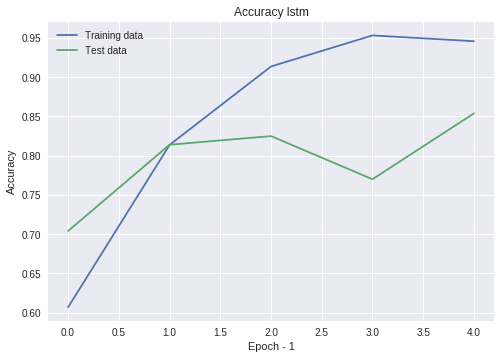

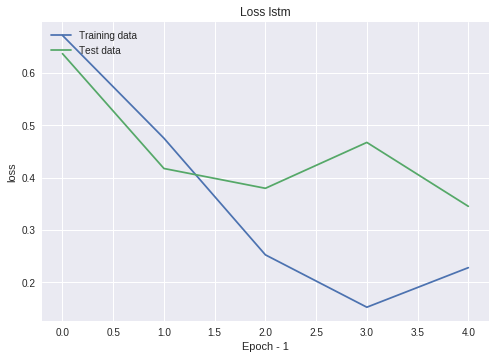

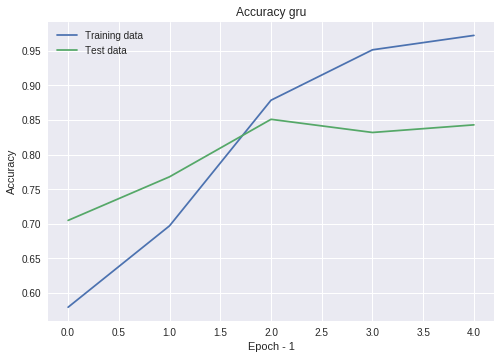

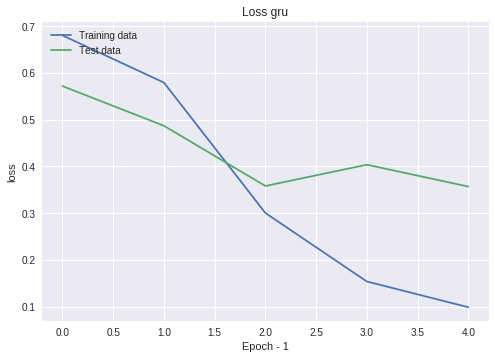

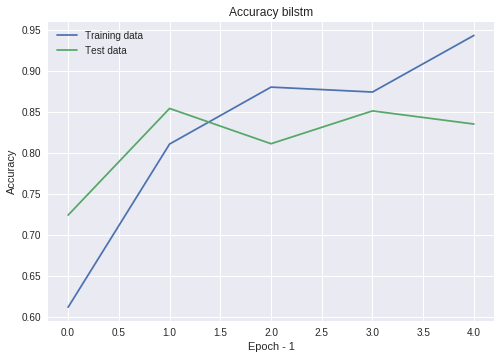

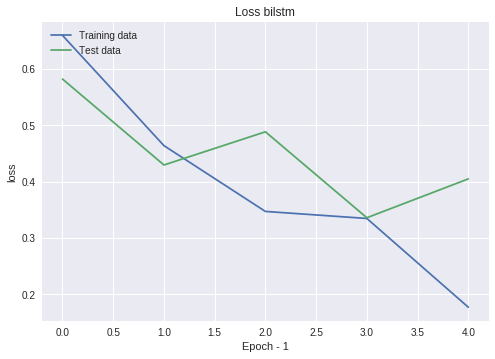

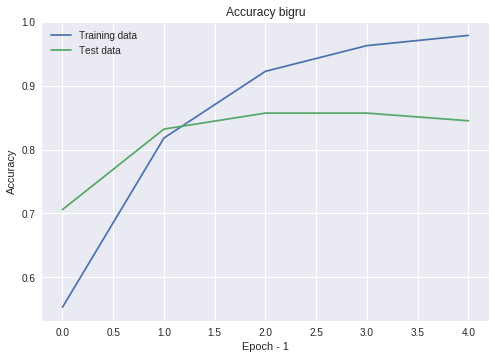

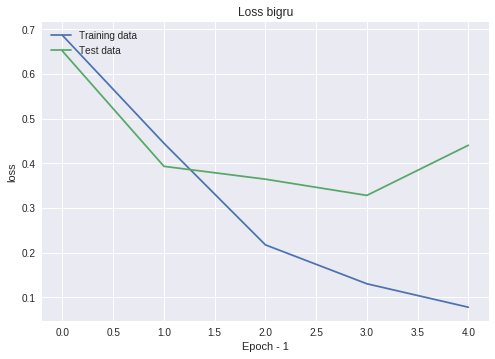

In [0]:
# YOUR CODE HERE 
import matplotlib.pyplot as plt

histories = [lstm_history, gru_history, bilstm_history, bigru_history]
titles = ['lstm', 'gru', 'bilstm', 'bigru']

for i, history in enumerate(histories):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Accuracy ' + titles[i])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch - 1')
  plt.legend(['Training data', 'Test data'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss '  + titles[i])
  plt.ylabel('loss')
  plt.xlabel('Epoch - 1')
  plt.legend(['Training data', 'Test data'], loc='upper left')
  plt.show()

In [0]:
d = {}
for i, history in enumerate(histories):
  d[titles[i] + ' accuracy'] = history.history['val_acc']
  d[titles[i] + ' loss'] = history.history['val_loss']
d['Epoch'] = [1, 2, 3, 4, 5]
df = pd.DataFrame(data=d)
df.set_index('Epoch', inplace=True)
display(df)

,bigru accuracy,bigru loss,bilstm accuracy,bilstm loss,gru accuracy,gru loss,lstm accuracy,lstm loss
Epoch,,,,,,,,
1,0.706,0.651472,0.724,0.582019,0.705,0.572033,0.704,0.636514
2,0.832,0.393214,0.854,0.429447,0.768,0.487111,0.814,0.417432
3,0.857,0.364419,0.811,0.488354,0.851,0.358311,0.825,0.379671
4,0.857,0.328047,0.851,0.335791,0.832,0.403826,0.770,0.467172
5,0.845,0.440431,0.835,0.404762,0.843,0.357101,0.854,0.345293


#### Present table comparison of model performance

#### Answer:

In the table presented above the accuracy and loss for the four different gate memory units are presented.  
For every unit the model has been trained for 5 epochs. We see the best result for lstm with a test set accuracy of 0.854 and a test set loss of 0.345293. The model using lstm will thus be used for the feature extracitn.  
We further notice that both lstm and bidirectional lstm were still increasing in the last epoch. This means that these results can likely be improved by running more epochs. The test set accuracy and loss for gru and bidirectional gru were slowly stopping to increase towards the fifth epoch and are thus unlikely to outperform the lstm units.

### 3. Feature extraction

#### Tasks: 

* Choose one model with the best performance and use the model to produce ”neural codes” (document embedding) of raw text (5000 instances of unseen validation set) from RNN layer.
*  Use tSNE to reduce the dimension of extracted text features (encoded version of 5000 documents) into two (2) dimensions and visualize it towards their sentiment labels.


In [0]:
# load the trained model
from keras.models import load_model
import tensorflow as tf

# YOUR CODE HERE
# choose the best model

model = load_model('lstm_model.h5', custom_objects={
    'tf':tf,
    'num_words':num_words})
model.load_weights('lstm_model.h5')

#### Produce Neural codes of text reviews

In [0]:
# YOUR CODE HERE
x_create_embedding = np.load(os.path.join('X_valid_word.npy'))
x_create_embedding = x_create_embedding[6000:11000]
y_create_embedding = np.load(os.path.join('y_valid_word.npy'))
y_create_embedding = y_create_embedding[6000:11000]

print(x_create_embedding[1].shape)
 
# define sub model to retrieve "neural codes" (document embedding) from recurrent layer
encoder_model = Model(inputs=model.input, outputs=model.get_layer("lstm_layer").output)
# generate "neural codes" (document embedding) from the model
doc_embeddings = encoder_model.predict(x_create_embedding)

(500,)


#### tSNE visualization

In [0]:
# YOUR CODE HERE

# use tSNE to plot document embedding on its sentiment label
from sklearn.manifold import TSNE
doc_embeddings_tsne = TSNE(n_components=2).fit_transform(doc_embeddings)

[1 0 0 ... 1 0 1]


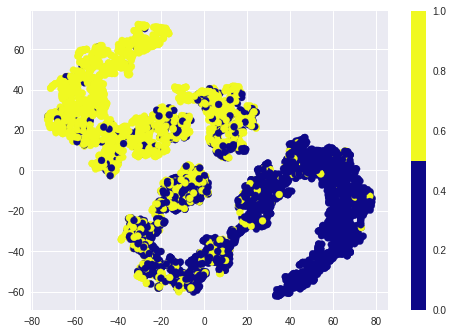

In [0]:
plt.scatter(doc_embeddings_tsne[:,0], doc_embeddings_tsne[:,1], c=y_create_embedding, cmap=plt.cm.get_cmap('plasma',2))
plt.colorbar()

### 4. One shot learning on multi-class classification

#### Tasks: 

* Use the RNN model that has been trained on binary classification task to extract features from different data set (Amazon product reviews)
* Define and implement an approach to assign labels on unlabelled set of reviews, by using the concept of "one shot learning"
* Compute accuracy, given ground truth labels
* Discuss the results 

Explain how the approach works.


#### Answer:

We first preprocess the new data exactly the same as we did before while using the vocabulary which we generated with the training data.  
We then create embeddings of the three label data points representing the three classes.  
After this we do the same for the test data.  
We then fit the neirest neighbour algorithm on the embeddings of our three labeled data points after which we compare the embeddings of our test data with these points.  
The embedding closest to the embedding of the newly presented datapoint is the embeddings whose class we will asign to the new datapoint.

In [0]:
# YOUR CODE HERE

# one shot learning task
amazon_reviews = pd.read_csv("example2_labelled.tsv", sep='\t')
display(amazon_reviews)

,label,review
0,camera,"I purchased the 20d in Feb 2011, around 7 year..."
1,mobilephone,It's been 3 weeks now and I've only had minor ...
2,laptop,I purchased this Z Series laptop about 5 month...
3,laptop,When I first got this laptop (at a garage sale...
4,mobilephone,I love this phone. I've had my own for over a ...
5,camera,I purchased this camera to replace my Casio EX...
6,camera,My perfect camera has to do two things very we...


In [0]:
# function to clean raw text data

def striphtml(html):
    p = re.compile(r'<.*?>')
    return p.sub('', html)

def clean(s):
    return re.sub(r'[^\x00-\x7f]', r'', s)
  
# FUNCTION to tokenize documents into array list of words
# you may also use nltk tokenizer, sklearn tokenizer, or keras tokenizer - 
# but for the tutorial in text modeling, we will use below function: 

def tokenizeWords(text):
    
    tokens = re.sub(r"[^a-z0-9]+", " ", text.lower()).split()
    return [str(strtokens) for strtokens in tokens]

# FUNCTION to create word-level vocabulary index

def indexingVocabulary(array_of_words):

    wordIndex = list(array_of_words)
    
    # we will later pad our sequence into fixed length, so
    # we will use '0' as the integer index of pad 
    wordIndex.insert(0,'<pad>')
    
    # index for word token '<start>' as a starting sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<start>')
    
    # index for word token '<end>' as an ending sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<end>')
    
    # index for word token '<unk>' or unknown words (out of vocabulary words) 
    wordIndex.append('<unk>')
    
    vocab = dict([(i,wordIndex[i]) for i in range(len(wordIndex))])
    
    return vocab

In [0]:

from keras.preprocessing import sequence

max_review_length = 500
example1_amazon =  pd.read_csv('example1_labelled.tsv', sep='\t')
example2_amazon = pd.read_csv('example2_labelled.tsv', sep='\t')

# Example1: this  will create a cleaned version of Example1
train_docs = []
train_labels = []
for review, label in zip(example1_amazon.review, example1_amazon.label):
    
    doc = clean(striphtml(review))
    doc = doc.lower() 
    train_docs.append(doc)
    train_labels.append(label)
    
# tokenize text from Example1
train_str_tokens = []
for i, text in enumerate(train_docs):
    
    # this will create our training corpus
    train_str_tokens.append(tokenizeWords(text))

# integer format of Example1 
train_int_input = []
for i, text in enumerate(train_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    train_int_input.append(int_tokens)
    
example1_amazon_arr = np.array(train_int_input)
example1_amazon_X = sequence.pad_sequences(example1_amazon_arr, maxlen=max_review_length)


# Example2: this  will create a cleaned version of Example2

test_docs = []
test_labels = []
for review, label in zip(example2_amazon.review, example2_amazon.label):
    
    doc = clean(striphtml(review))
    doc = doc.lower() 
    test_docs.append(doc)
    test_labels.append(label)

    
# tokenize text from Example2
train_str_tokens = []
for i, text in enumerate(test_docs):
    
    # this will create our training corpus
    train_str_tokens.append(tokenizeWords(text))

# integer format of Example2 
train_int_input = []
for i, text in enumerate(train_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    train_int_input.append(int_tokens)
    
example2_amazon_arr = np.array(train_int_input)
example2_amazon_X = sequence.pad_sequences(example2_amazon_arr, maxlen=max_review_length)

In [0]:
#Create embeddings
example1_embeddings = encoder_model.predict(example1_amazon_X)
example2_embeddings = encoder_model.predict(example2_amazon_X)

In [0]:
from sklearn.neighbors import NearestNeighbors

#Find the corresponding class using nearest neighbour.
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(example1_embeddings)

nn = neigh.kneighbors(example2_embeddings)

In [0]:
#Compare the labels and print the accuracy
example2_classes = nn[1][:, 0]
theClasses = []
for i, classNumber in enumerate(example2_classes):
  theClasses.append(train_labels[classNumber])
  
print('Nearest neighbours: ', nn)
print("Correct classes", test_labels)
print("Classes found", theClasses)

correct = (np.asarray(test_labels) == np.asarray(theClasses))
print("Percentage classified correctly (accuracy) : ", np.sum(correct)/len(theClasses))

Nearest neighbours:  (array([[0.04698169, 0.5679738 , 0.7667478 ],
       [1.2558521 , 1.4540079 , 1.9991429 ],
       [0.7206506 , 1.2378423 , 1.4249254 ],
       [0.14464626, 0.5141198 , 0.7053019 ],
       [0.31468713, 0.7930587 , 0.9808008 ],
       [0.808977  , 1.0050554 , 1.5527412 ],
       [0.28600857, 0.40395182, 0.44369873]], dtype=float32), array([[1, 2, 0],
       [0, 2, 1],
       [1, 2, 0],
       [1, 2, 0],
       [1, 2, 0],
       [0, 2, 1],
       [2, 1, 0]]))
Correct classes ['camera', 'mobilephone', 'laptop', 'laptop', 'mobilephone', 'camera', 'camera']
Classes found ['laptop', 'camera', 'laptop', 'laptop', 'laptop', 'camera', 'mobilephone']
Percentage classified correctly (accuracy) :  0.42857142857142855


In [0]:
word_indices = np.load('words_indices.npy')
indices_words = np.load('indices_words.npy')

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Discuss the result. Why it works -- or why it does not work.

#### Answer:

The classifier does perform beter than random guessing. It however does not perform well on our seven examples. The embeddings we use are trained to pick on structures that represent emotion, these representations do thus not need to say anything about the type of product. The results show that there might be some features in the representation that indicate the type of product, however not enough to make any accurate predictions. 